In [9]:
# ============== KERNEL PCA ANALYSIS ==============
# This notebook applies Kernel PCA to explore nonlinear dimensionality reduction
# for separating healthy vs stroke samples

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA, PCA

sns.set_style("whitegrid")
%matplotlib inline

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [10]:
# ============== LOAD AND PREPARE DATA ==============
file_path = '../data/joints/cva_data/output/final_data.csv'
df = pd.read_csv(file_path)

# Remove problematic column
df = df.drop(columns=['LDL direct | Instance 1'], errors='ignore')

print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())

# Select numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns.drop('Participant ID', errors='ignore')
print(f"\nNumerical features: {len(numerical_columns)}")


Dataset shape: (8539, 41)

Label distribution:
label
Healthy               6694
Ischemic Stroke       1199
Hemorrhagic Stroke     646
Name: count, dtype: int64

Numerical features: 39


In [11]:
# ============== PREPARE FEATURES ==============
X = df[numerical_columns].copy()

# Unite both stroke types into a single "Stroke" category
y = np.where(df['label'] == 'Healthy', 'Healthy', 'Stroke')

# Create binary labels for metrics computation
y_binary = np.where(y == 'Healthy', 0, 1)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Healthy samples: {np.sum(y_binary == 0)}")
print(f"Stroke samples: {np.sum(y_binary == 1)}")


Feature matrix shape: (8539, 39)
Healthy samples: 6694
Stroke samples: 1845


In [12]:
# ============== APPLY KERNEL PCA WITH DIFFERENT KERNELS ==============
# We'll compare RBF, Polynomial, and Sigmoid kernels with Linear PCA as baseline

N_COMPONENTS = 2

# Define kernels to test
kernels = {
    'Linear PCA': PCA(n_components=N_COMPONENTS),
    'RBF Kernel': KernelPCA(n_components=N_COMPONENTS, kernel='rbf', gamma=0.01),
    'Polynomial (d=3)': KernelPCA(n_components=N_COMPONENTS, kernel='poly', degree=3),
    'Sigmoid': KernelPCA(n_components=N_COMPONENTS, kernel='sigmoid', gamma=0.01),
    'Cosine': KernelPCA(n_components=N_COMPONENTS, kernel='cosine')
}

# Apply each kernel and store results
results = {}
for name, model in kernels.items():
    print(f"Fitting {name}...", end=" ")
    X_transformed = model.fit_transform(X_scaled)
    results[name] = X_transformed
    print("Done!")

print(f"\nAll {len(kernels)} methods fitted successfully!")


Fitting Linear PCA... Done!
Fitting RBF Kernel... Done!
Fitting Polynomial (d=3)... Done!
Fitting Sigmoid... Done!
Fitting Cosine... Done!

All 5 methods fitted successfully!


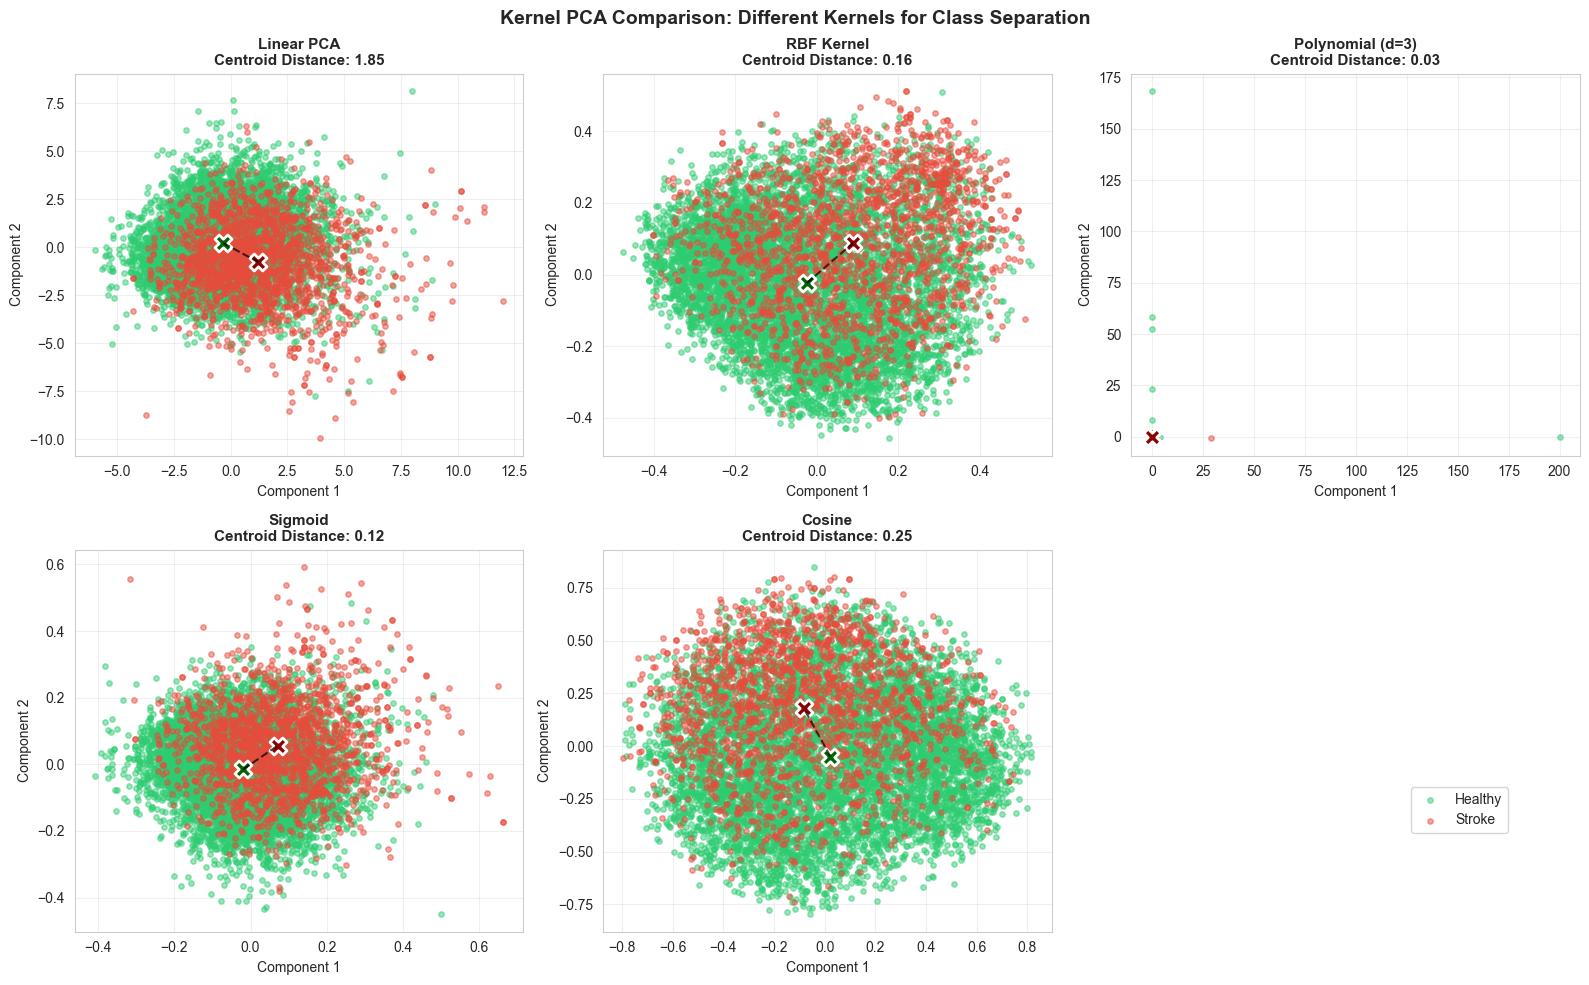

In [13]:
# ============== VISUALIZE KERNEL PCA RESULTS ==============

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

colors = {'Healthy': '#2ecc71', 'Stroke': '#e74c3c'}

for idx, (name, X_trans) in enumerate(results.items()):
    ax = axes[idx]
    
    for label in ['Healthy', 'Stroke']:
        mask = y == label
        ax.scatter(X_trans[mask, 0], X_trans[mask, 1], 
                   c=colors[label], alpha=0.5, s=15, label=label)
    
    # Calculate and show centroid distances
    healthy_cent = X_trans[y_binary == 0].mean(axis=0)
    stroke_cent = X_trans[y_binary == 1].mean(axis=0)
    cent_dist = np.linalg.norm(healthy_cent - stroke_cent)
    
    ax.scatter(*healthy_cent, c='darkgreen', s=150, marker='X', edgecolors='white', linewidths=2)
    ax.scatter(*stroke_cent, c='darkred', s=150, marker='X', edgecolors='white', linewidths=2)
    ax.plot([healthy_cent[0], stroke_cent[0]], [healthy_cent[1], stroke_cent[1]], 'k--', linewidth=1.5, alpha=0.7)
    
    ax.set_title(f'{name}\nCentroid Distance: {cent_dist:.2f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True, alpha=0.3)

# Hide empty subplot
axes[-1].axis('off')

# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.95, 0.15), fontsize=10)

plt.suptitle('Kernel PCA Comparison: Different Kernels for Class Separation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


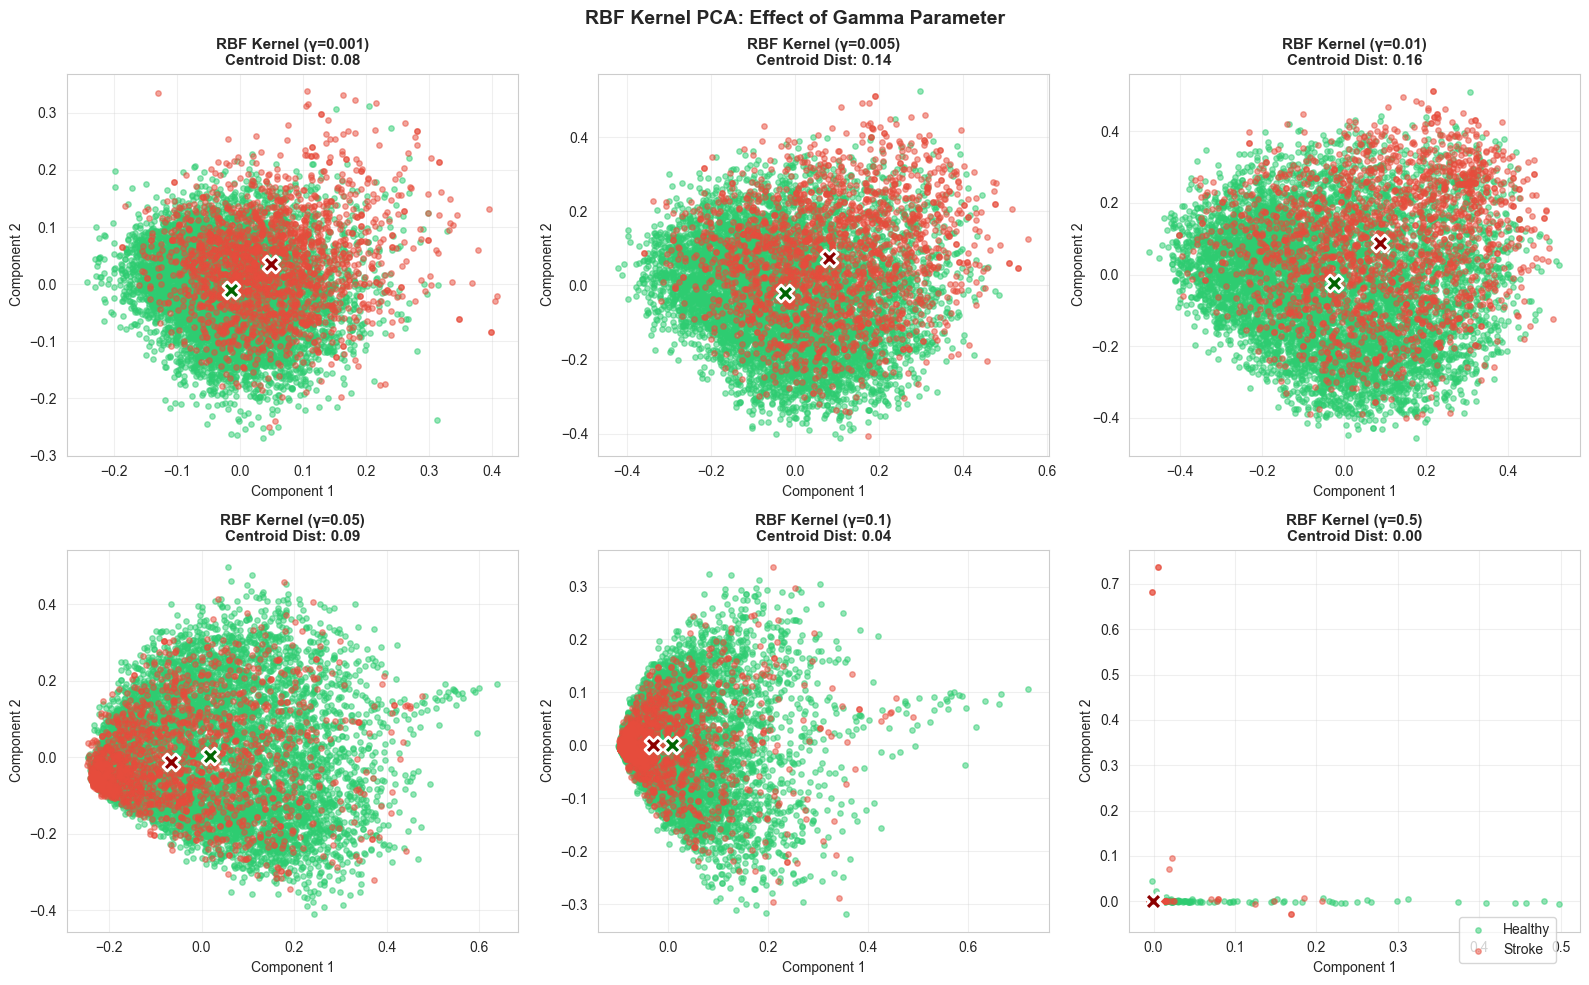

In [14]:
# ============== RBF KERNEL GAMMA TUNING ==============
# The gamma parameter controls the width of the RBF kernel

gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, gamma in enumerate(gammas):
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kpca = kpca.fit_transform(X_scaled)
    
    ax = axes[idx]
    
    for label in ['Healthy', 'Stroke']:
        mask = y == label
        ax.scatter(X_kpca[mask, 0], X_kpca[mask, 1], 
                   c=colors[label], alpha=0.5, s=15, label=label)
    
    # Centroids
    healthy_cent = X_kpca[y_binary == 0].mean(axis=0)
    stroke_cent = X_kpca[y_binary == 1].mean(axis=0)
    cent_dist = np.linalg.norm(healthy_cent - stroke_cent)
    
    ax.scatter(*healthy_cent, c='darkgreen', s=150, marker='X', edgecolors='white', linewidths=2)
    ax.scatter(*stroke_cent, c='darkred', s=150, marker='X', edgecolors='white', linewidths=2)
    
    ax.set_title(f'RBF Kernel (γ={gamma})\nCentroid Dist: {cent_dist:.2f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True, alpha=0.3)

# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.98, 0.02), fontsize=10)

plt.suptitle('RBF Kernel PCA: Effect of Gamma Parameter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [15]:
# ============== QUANTITATIVE COMPARISON ==============
# Compare separation metrics across different kernels

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression

def compute_separation_metrics(X_trans, y_bin):
    """Compute separation metrics for the transformed data."""
    metrics = {}
    
    # Centroid distance
    healthy_cent = X_trans[y_bin == 0].mean(axis=0)
    stroke_cent = X_trans[y_bin == 1].mean(axis=0)
    metrics['centroid_dist'] = np.linalg.norm(healthy_cent - stroke_cent)
    
    # k-NN purity (k=10)
    nn = NearestNeighbors(n_neighbors=11)
    nn.fit(X_trans)
    _, indices = nn.kneighbors(X_trans)
    neighbor_labels = y_bin[indices[:, 1:]]
    metrics['knn_purity'] = (neighbor_labels == y_bin.reshape(-1, 1)).mean()
    
    # Linear separability
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_trans, y_bin)
    metrics['linear_sep'] = lr.score(X_trans, y_bin)
    
    return metrics

# Compute metrics for all kernels
print("="*70)
print("KERNEL PCA COMPARISON - SEPARATION METRICS")
print("="*70)
print(f"{'Kernel':<25} {'Centroid Dist':>15} {'k-NN Purity':>15} {'Linear Sep':>15}")
print("-"*70)

for name, X_trans in results.items():
    metrics = compute_separation_metrics(X_trans, y_binary)
    print(f"{name:<25} {metrics['centroid_dist']:>15.3f} {metrics['knn_purity']:>14.1%} {metrics['linear_sep']:>14.1%}")

print("="*70)


KERNEL PCA COMPARISON - SEPARATION METRICS
Kernel                      Centroid Dist     k-NN Purity      Linear Sep
----------------------------------------------------------------------
Linear PCA                          1.852          71.0%          80.1%
RBF Kernel                          0.159          70.9%          79.9%
Polynomial (d=3)                    0.032          67.5%          78.4%
Sigmoid                             0.116          71.1%          80.0%
Cosine                              0.252          70.4%          79.2%


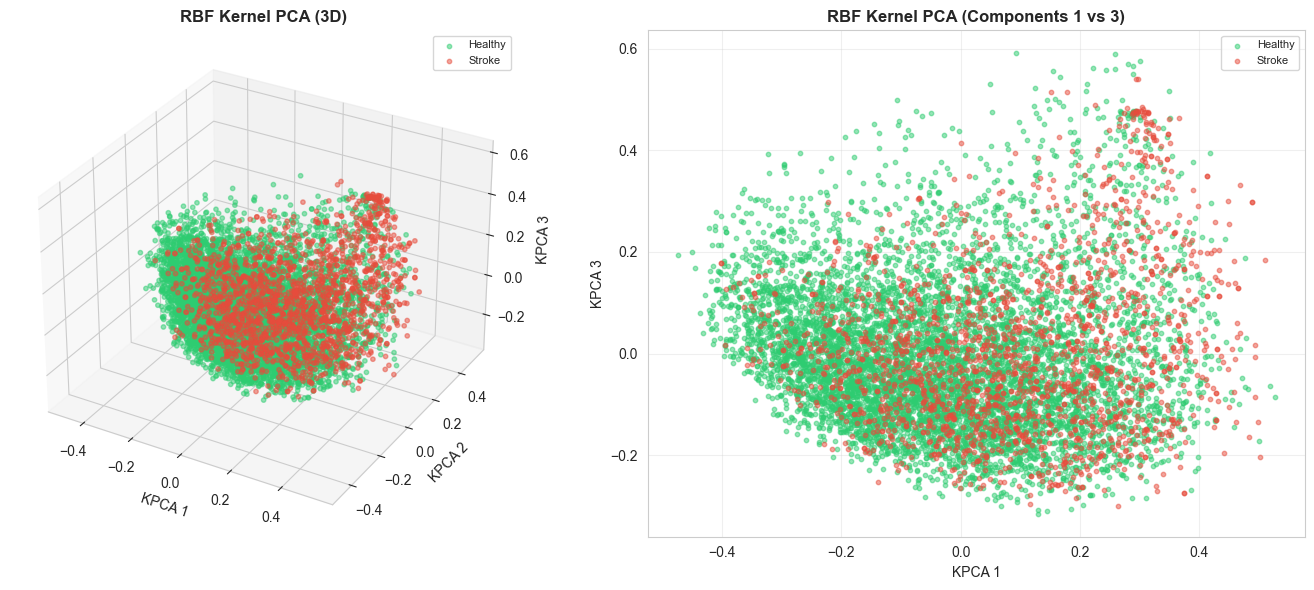

In [16]:
# ============== 3D KERNEL PCA VISUALIZATION ==============
# Apply RBF Kernel PCA with 3 components for 3D visualization

kpca_3d = KernelPCA(n_components=3, kernel='rbf', gamma=0.01)
X_kpca_3d = kpca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(14, 6))

# 3D plot
ax1 = fig.add_subplot(121, projection='3d')

for label in ['Healthy', 'Stroke']:
    mask = y == label
    ax1.scatter(X_kpca_3d[mask, 0], X_kpca_3d[mask, 1], X_kpca_3d[mask, 2],
                c=colors[label], alpha=0.5, s=10, label=label)

ax1.set_xlabel('KPCA 1')
ax1.set_ylabel('KPCA 2')
ax1.set_zlabel('KPCA 3')
ax1.set_title('RBF Kernel PCA (3D)', fontweight='bold')
ax1.legend(fontsize=8)

# Pairplot of components 1 vs 3
ax2 = fig.add_subplot(122)
for label in ['Healthy', 'Stroke']:
    mask = y == label
    ax2.scatter(X_kpca_3d[mask, 0], X_kpca_3d[mask, 2],
                c=colors[label], alpha=0.5, s=10, label=label)
ax2.set_xlabel('KPCA 1')
ax2.set_ylabel('KPCA 3')
ax2.set_title('RBF Kernel PCA (Components 1 vs 3)', fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
